In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim import Optimizer

import numpy as np
import pandas as pd
import os

In [42]:
# load data
data = pd.read_csv("nn_data_test.csv")
data.head()

data = data.sample(frac=1)

test  = data.iloc[:1000,:]
train = data.iloc[0:,:]

# train set
y_train = torch.tensor(train['transfer'].values)
y_train = y_train.to(torch.float32)

x_train = train.drop(['transfer', 'ppt_id','Unnamed: 0'], axis=1).to_numpy()
x_train = torch.from_numpy(x_train)
x_train = x_train.to(torch.float32)

# test set
y_test = torch.tensor(test['transfer'].values)
y_test = y_test.to(torch.float32)

x_test = test.drop(['transfer', 'ppt_id','Unnamed: 0'], axis=1).to_numpy()
x_test = torch.from_numpy(x_test)
x_test = x_test.to(torch.float32)

x_train.size(dim=1)

24

In [43]:
class Net(nn.Module):
    
    def __init__(self, n_features, n_hidden, model_path: str = r'.\models',
        model_name: str = 'MLP',):
        super(Net, self).__init__()
            
        self.layer1  = nn.Linear(n_features, n_hidden, bias=True)
        self.layer2  = nn.Linear(n_hidden, 1, bias=False)       
        self.relu    = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()
        
        with torch.no_grad():
            self.layer1.weight.mul_(w_scale)
            self.layer2.weight.mul_(w_scale)
            
    def forward(self, x):
        h1  = self.layer1(x)
        h2  = self.layer2(h1)
        out = self.sigmoid(h2)
        return out
    
    def save_model(self, checkpoint_number: int, optimizer: Optimizer):
        """Saves model and optimizer state."""
        checkpoint_number = str(checkpoint_number)
        saveroot = os.path.join(self.model_path)
        savepath = os.path.join(saveroot, f'{self.model_name}_{checkpoint_number}.pth')
        if not os.path.exists(saveroot):
            os.mkdir(saveroot)

        torch.save({
            'model_name': self.model_name,
            'model_params': self.state_dict(),
            'optimizer': optimizer,
            'optimizer_params': optimizer.state_dict()},
            savepath)
        print(fr'Saved model to {savepath}')

In [44]:
class CustomDataset(Dataset):
    def __init__(self, input_tensors):
        assert input_tensors[0].size(0) == input_tensors[0].size(0)
        self.input_tensors = input_tensors

    def __getitem__(self, index):
        x = self.input_tensors[0][index]
        y = self.input_tensors[1][index]
        return x, y

    def __len__(self):
        return self.input_tensors[0].size(0)

In [45]:
 def training_loop(hyperparams: dict, net, train_loader, device='cpu'):

    
    optimizer = hyperparams['optimizer']
    loss_fn   = hyperparams['loss_fn']
    
    loss_history = np.array([])
    
    for epoch in range(hyperparams['num_epochs']):

        # train
        net.train()
        epoch_loss  = 0.0
        correct     = 0
        total_count = 0
        
        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            
            inputs = torch.nan_to_num(inputs)
            
            optimizer.zero_grad()
            outputs = net(inputs).squeeze()
            
            loss    = loss_fn(outputs, labels)
            
            loss.backward()
            optimizer.step()

            #print(outputs)
            # calculate accuracy and loss
            total_count += labels.size(0)
            predictions = (outputs > 0.5)
            correct     += (predictions == (labels>0.5)).sum().item()
            epoch_loss  += loss.item()
        
        loss_history = np.append(loss_history, np.array([epoch_loss / len(train_loader)]))
        
        print(f'Epoch {epoch} train loss: {round(epoch_loss / len(train_loader),4)}')
        print(f'Epoch {epoch} train accuracy: {round(100 * correct / total_count,3)}%')
        
    return loss_history



In [46]:
train_set    = CustomDataset(input_tensors=(x_train, y_train))
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
                       
n_hidden   = 100
n_features = x_train.size(dim=1)
w_scale    = 0.001

net = Net(n_features,n_hidden,w_scale)

hyperparams = {'optimizer': Adam(net.parameters(), lr=1e-5),
                       'loss_fn': nn.MSELoss(),
                       'num_epochs': 100,
                       'model_save_interval': 1}

loss_history = training_loop(hyperparams, net, train_loader, device='cpu')

loss_history

Epoch 0 train loss: 0.0715
Epoch 0 train accuracy: 56.826%
Epoch 1 train loss: 0.0687
Epoch 1 train accuracy: 57.152%
Epoch 2 train loss: 0.0639
Epoch 2 train accuracy: 57.64%
Epoch 3 train loss: 0.0561
Epoch 3 train accuracy: 74.775%
Epoch 4 train loss: 0.0472
Epoch 4 train accuracy: 80.123%
Epoch 5 train loss: 0.0396
Epoch 5 train accuracy: 80.787%
Epoch 6 train loss: 0.0344
Epoch 6 train accuracy: 80.736%
Epoch 7 train loss: 0.0314
Epoch 7 train accuracy: 80.837%
Epoch 8 train loss: 0.0298
Epoch 8 train accuracy: 80.887%
Epoch 9 train loss: 0.0291
Epoch 9 train accuracy: 80.749%
Epoch 10 train loss: 0.0288
Epoch 10 train accuracy: 80.686%
Epoch 11 train loss: 0.0286
Epoch 11 train accuracy: 80.724%
Epoch 12 train loss: 0.0286
Epoch 12 train accuracy: 80.762%
Epoch 13 train loss: 0.0285
Epoch 13 train accuracy: 80.799%
Epoch 14 train loss: 0.0285
Epoch 14 train accuracy: 80.799%
Epoch 15 train loss: 0.0285
Epoch 15 train accuracy: 80.824%
Epoch 16 train loss: 0.0284
Epoch 16 train ac

array([0.07149818, 0.06866438, 0.06393812, 0.05611777, 0.04721966,
       0.03959141, 0.03439698, 0.031384  , 0.02982706, 0.02908622,
       0.02881236, 0.02864744, 0.02855977, 0.02853207, 0.02848385,
       0.02848851, 0.02842051, 0.02838794, 0.02838305, 0.02836511,
       0.02833468, 0.02835001, 0.0282902 , 0.02827576, 0.02826157,
       0.02829307, 0.02823379, 0.02823888, 0.02821345, 0.02820445,
       0.02825267, 0.02820049, 0.0282107 , 0.02819201, 0.02819141,
       0.02818526, 0.02815147, 0.02817088, 0.0281657 , 0.02816082,
       0.028143  , 0.0281346 , 0.02814573, 0.02814481, 0.02815934,
       0.02813289, 0.02810745, 0.02813746, 0.02813107, 0.02811279,
       0.02811026, 0.02809302, 0.02811304, 0.02812887, 0.02809794,
       0.02819468, 0.02813198, 0.02812529, 0.02815962, 0.0281305 ,
       0.02811921, 0.02809954, 0.02809351, 0.02810919, 0.02811934,
       0.02810229, 0.02812223, 0.0280997 , 0.02810739, 0.02810265,
       0.02807547, 0.028073  , 0.02810252, 0.02814773, 0.02809

0.028778519481420517


Text(0.5, 1.0, 'MLP')

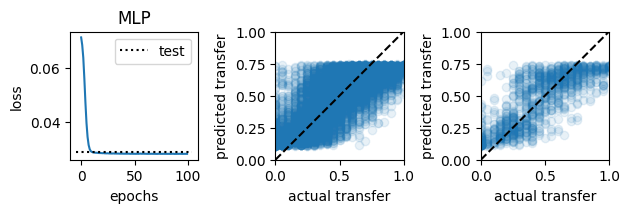

In [47]:
net.eval()

test_outputs = net(torch.nan_to_num(x_test)).squeeze()
train_outputs = net(torch.nan_to_num(x_train)).squeeze()

# test loss
loss_fn = hyperparams['loss_fn']
loss    = loss_fn(test_outputs, y_test).item()

print(loss)

# plot
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)

# plot loss
ax0.plot(list(range(0,hyperparams['num_epochs'])),loss_history)
a = ax0.plot(ax0.get_xlim(),[loss,loss], ':k', label='test')
ax0.set_xlabel('epochs')
ax0.set_ylabel('loss')
ax0.legend(handles=a)

# train set
ax1.scatter(y_train.detach().numpy(), train_outputs.detach().numpy(), alpha=.1)
ax1.plot([0,1],[0,1],'k--')
ax1.set_xlabel('actual transfer')
ax1.set_ylabel('predicted transfer')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# test set
ax2.scatter(y_test.detach().numpy(), test_outputs.detach().numpy(), alpha=.1)
ax2.plot([0,1],[0,1],'k--')
ax2.set_xlabel('actual transfer')
ax2.set_ylabel('predicted transfer')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

plt.tight_layout()
x_left, x_right = ax0.get_xlim()
y_low, y_high   = ax0.get_ylim()
ax0.set_aspect(abs((x_right-x_left)/(y_low-y_high)))
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax0.set_title('MLP')

In [48]:
metrics.r2_score(test_outputs.detach().numpy(), y_test.detach().numpy())

0.3172392392899265

0.027974552


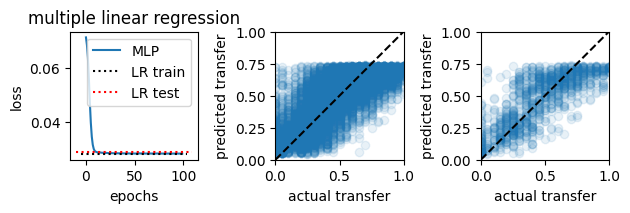

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

mlr = LinearRegression()  
mlr.fit(torch.nan_to_num(x_train), torch.nan_to_num(y_train))

train_outputs_lin = mlr.predict(torch.nan_to_num(x_train))
test_outputs_lin  = mlr.predict(torch.nan_to_num(x_test))

loss_lin_train = metrics.mean_squared_error(y_train, train_outputs_lin)
loss_lin_test = metrics.mean_squared_error(y_test, test_outputs_lin)


# plot
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)

# plot loss
a, = ax0.plot(list(range(0,hyperparams['num_epochs'])),loss_history, label = 'MLP')
b, = ax0.plot(ax0.get_xlim(),[loss_lin_train,loss_lin_train], ':k', label = 'LR train')
c, = ax0.plot(ax0.get_xlim(),[loss_lin_test,loss_lin_test], ':r', label = 'LR test')
ax0.set_xlabel('epochs')
ax0.set_ylabel('loss')
ax0.legend(handles=[a,b,c])


# train set
ax1.scatter(y_train.detach().numpy(), train_outputs_lin, alpha=.1)
ax1.plot([0,1],[0,1],'k--')
ax1.set_xlabel('actual transfer')
ax1.set_ylabel('predicted transfer')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# test set
ax2.scatter(y_test.detach().numpy(), test_outputs_lin, alpha=.1)
ax2.plot([0,1],[0,1],'k--')
ax2.set_xlabel('actual transfer')
ax2.set_ylabel('predicted transfer')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

plt.tight_layout()
x_left, x_right = ax0.get_xlim()
y_low, y_high   = ax0.get_ylim()
ax0.set_aspect(abs((x_right-x_left)/(y_low-y_high)))
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax0.set_title('multiple linear regression')

print(loss_lin_train)


In [51]:
metrics.r2_score(test_outputs_lin, y_test.detach().numpy())

0.324016536913444

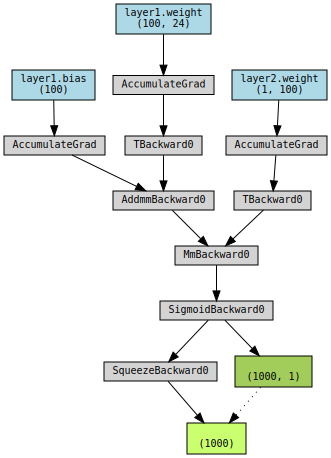

In [50]:
from torchviz import make_dot


n_hidden   = 100
n_features = x_train.size(dim=1)

net = Net(n_features,n_hidden)
test_outputs = net(torch.nan_to_num(x_test)).squeeze()

make_dot(test_outputs, params=dict(net.named_parameters()))
